In [1]:
import os
import pvlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import warnings
warnings.simplefilter('ignore')

from pvlib.modelchain import ModelChain
from pvlib.location import Location
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.iotools import get_pvgis_tmy

## Inputting temperature model parameters, PV module specification and inverter module specification

In [2]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# load some module and inverter specifications from the sandia database
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

In [3]:
# Selected the most recent module for better accuracy
colNames = sandia_modules.columns[sandia_modules.columns.str.contains(pat = '2014')] 
print(colNames)

Index(['Silevo_Triex_U300_Black__2014_'], dtype='object')


In [4]:
# Specify the version of module and inverter that will be used for the modelling
sandia_module = sandia_modules['Silevo_Triex_U300_Black__2014_']
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [5]:
sandia_module

Vintage                                                          2014
Area                                                             1.68
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                            5.771
Voco                                                          68.5983
Impo                                                            5.383
Vmpo                                                          55.4547
Aisc                                                           0.0003
Aimp                                                          -0.0003
C0                                                              0.995
C1                                                              0.005
Bvoco                                                         -0.1913
Mbvoc               

In [6]:
cec_inverter

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

## locating Holywell House for solar positioning, weather information gathering (ghi, dni, dhi)

In [7]:
# Specifying the  Latitude, longitude, name, altitude, timezone of Holywell House for weather information data injection
location = Location(latitude=51.74621631454201, longitude=-1.2736046573692332, tz='UTC', name='Holywell House' )

# Input the selected PV module model, inverter model, tilt & azimuth of the rooftop PV system
# Tilt=20degree, azimuth=35degree
system = PVSystem(surface_tilt=35, surface_azimuth=200,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter,
                  temperature_model_parameters=temperature_model_parameters)

# Creating a model for the specified set of parameters used
model = ModelChain(system, location)
print(model)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [8]:
# Pulling weather data directly from the PVGIS database to the environment
# Weather data injected in this case is computed using 10 years of historical data from 2010 till 2020 with some
# mathematical computation such as random sampling etc
weather, months, inputs, meta = get_pvgis_tmy(51.74621631454201, -1.2736046573692332, startyear=2010, 
                                             endyear=2020, map_variables=True,
                                              url='https://re.jrc.ec.europa.eu/api/v5_2/')

weather

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2020-01-01 00:00:00+00:00,3.04,93.36,0.0,0.0,0.0,303.34,1.92,119.0,102350.0
2020-01-01 01:00:00+00:00,3.39,93.19,0.0,0.0,0.0,309.49,1.93,121.0,102310.0
2020-01-01 02:00:00+00:00,3.74,93.01,0.0,0.0,0.0,315.64,1.94,125.0,102280.0
2020-01-01 03:00:00+00:00,4.09,92.84,0.0,0.0,0.0,321.80,1.95,126.0,102280.0
2020-01-01 04:00:00+00:00,4.43,92.67,0.0,0.0,0.0,327.95,1.96,125.0,102261.0
...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,1.30,94.23,0.0,0.0,0.0,272.58,1.87,325.0,99687.0
2020-12-31 20:00:00+00:00,1.65,94.06,0.0,0.0,0.0,278.73,1.88,334.0,99697.0
2020-12-31 21:00:00+00:00,2.00,93.89,0.0,0.0,0.0,284.88,1.89,334.0,99677.0


Text(0.5, 1.0, 'Irradiance Received According to Geographical Location for the first 7 days')

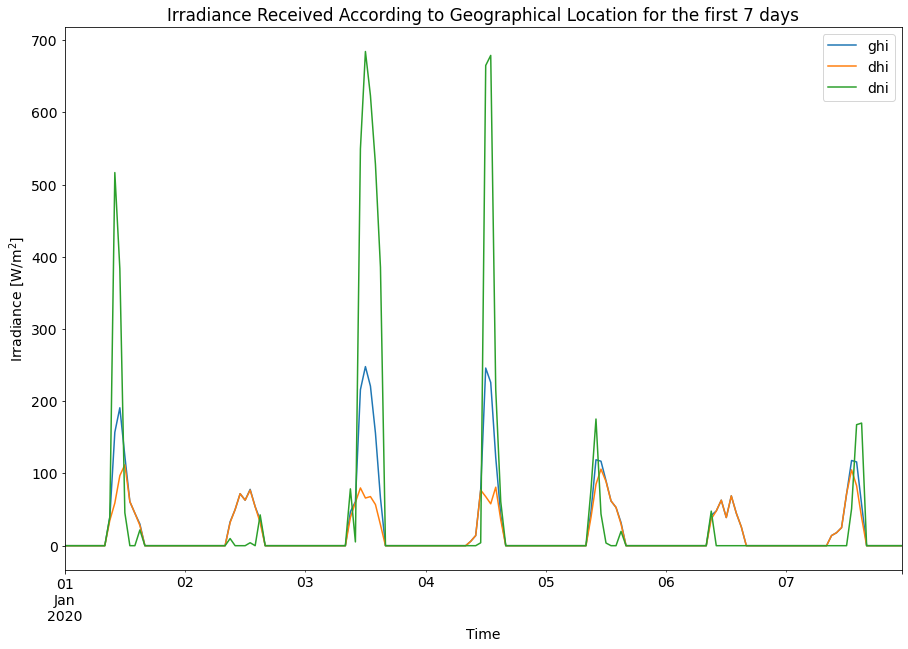

In [12]:
first_week = weather.head(24*7)  # Plotting 7 days, each one has 24 hours or entries
first_week[['ghi', 'dhi', 'dni']].plot(figsize=(15,10))
plt.ylabel('Irradiance [W/m$^2$]');
plt.xlabel('Time')
plt.title('Irradiance Received According to Geographical Location for the first 7 days')

## Solar sun path positioning and visualization 

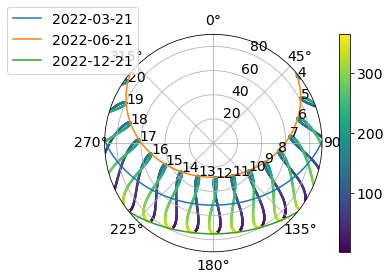

In [13]:
# Solar Positioning 

from pvlib import solarposition

tz = 'UTC'
lat, lon = 51.746170887443185, -1.2734710575173236

times = pd.date_range('2022-01-01 00:00:00', '2023-01-01', freq='H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

# draw individual days
for date in pd.to_datetime(['2022-03-21', '2022-06-21', '2022-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]
    label = date.strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')
# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

# POA irradiance calculation using ghi, dni & dhi and the solar positioning 

In [14]:
# TMY datasets are right-labeled hourly intervals, computing the median of each intervals
times = weather.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
time(UTC),,,,,,
2020-01-01 00:00:00+00:00,150.388204,150.388204,-60.388204,-60.388204,342.020377,-3.071789
2020-01-01 01:00:00+00:00,151.006029,151.006029,-61.006029,-61.006029,10.391338,-3.091657
2020-01-01 02:00:00+00:00,147.280657,147.280657,-57.280657,-57.280657,36.489894,-3.111515
2020-01-01 03:00:00+00:00,140.500665,140.500665,-50.500665,-50.500665,57.019667,-3.131365
2020-01-01 04:00:00+00:00,132.092006,132.092006,-42.092006,-42.092006,72.929444,-3.151206


In [15]:
df_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=35,  # tilted 35 degrees from horizontal - the roof angle 
    surface_azimuth=200,  # facing slightly East from South
    dni=weather['dni'],
    ghi=weather['ghi'],
    dhi=weather['dhi'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

df_poa

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
time(UTC),,,,,
2020-01-01 00:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-01-01 01:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-01-01 02:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-01-01 03:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-01-01 04:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-12-31 19:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-12-31 20:00:00+00:00,0.0,-0.0,0.0,0.0,0.0
2020-12-31 21:00:00+00:00,0.0,-0.0,0.0,0.0,0.0


Since the constructed weather data is randomly sampled from any month of the past 10 years, therefore we need to reset the timeline to this year. 

In [16]:
daterange = pd.date_range(start='1/01/2022 00:00:00', end='31/12/2022 23:00:00', freq='H')

In [17]:
weather_t = weather.copy()
weather_t['date'] = daterange
df_poa['date'] = daterange 

In [18]:
weather_t.index = pd.to_datetime(weather_t['date'])
weather_t.drop('date', axis = 1, inplace = True)
df_poa.index = pd.to_datetime(df_poa['date'])
df_poa.drop('date', axis = 1, inplace = True)

Text(0.5, 1.0, 'GHI vs POA received throughout the year')

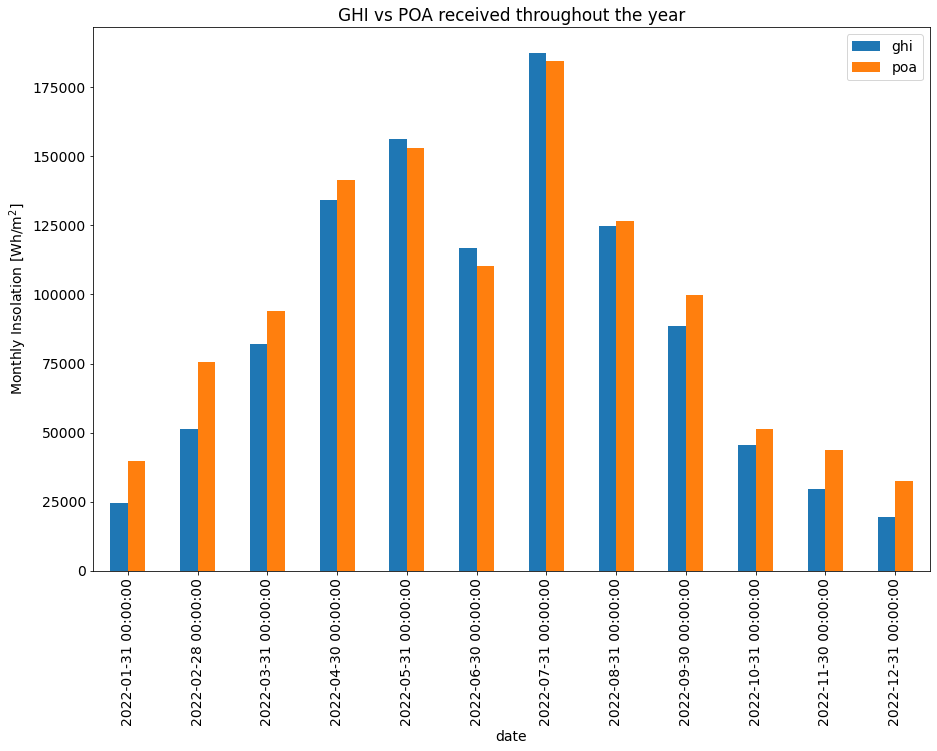

In [19]:
df_poa_ghi = pd.DataFrame({
    'ghi': weather_t['ghi'],
    'poa': df_poa['poa_global'],
})
df_monthly = df_poa_ghi.resample('M').sum()
df_monthly.plot.bar(figsize=(15,10))
plt.ylabel('Monthly Insolation [Wh/m$^2$]');
plt.title('GHI vs POA received throughout the year')

Text(0.5, 1.0, 'GHI vs POA received on Summer Solstice ')

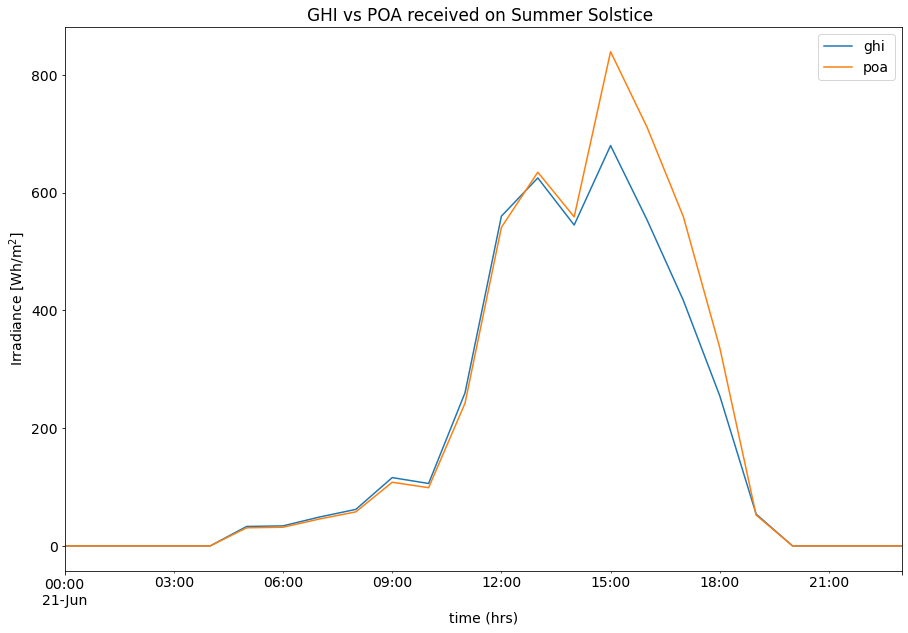

In [20]:
df_poa_ghi.loc['2022-06-21'].plot(figsize=(15,10), label='Summer Solstice')
plt.ylabel('Irradiance [Wh/m$^2$]');
plt.xlabel('time (hrs)')
plt.title('GHI vs POA received on Summer Solstice ')

Text(0.5, 1.0, 'GHI vs POA received on Winter Solstice ')

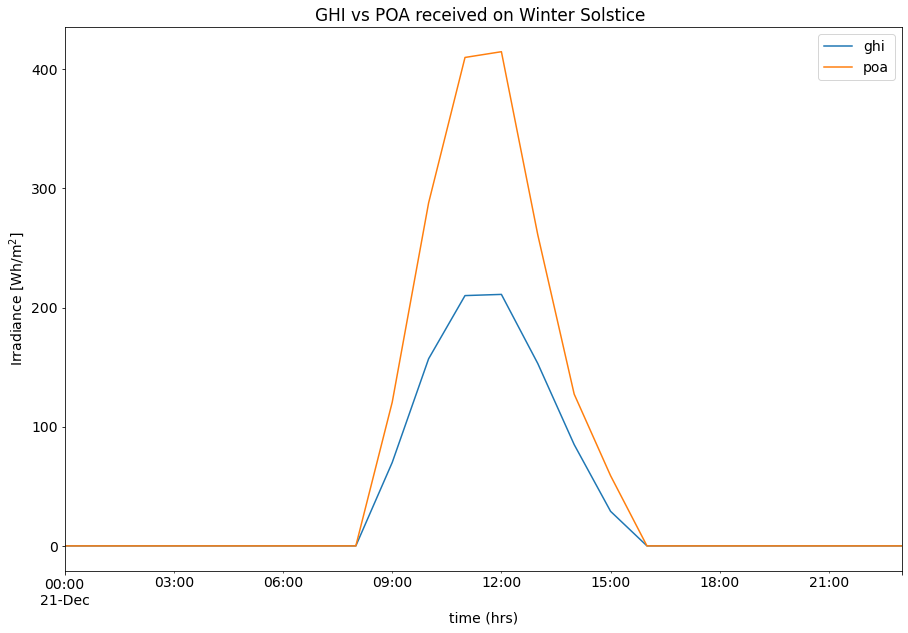

In [21]:
df_poa_ghi.loc['2022-12-21'].plot(figsize=(15,10), label='Winter Solstice')
plt.ylabel('Irradiance [Wh/m$^2$]');
plt.xlabel('time (hrs)')
plt.title('GHI vs POA received on Winter Solstice ')

## PV module power output modelling 

### Cell Temperature 

In [22]:
df_poa_global = df_poa['poa_global']
df_poa_global

date
2022-01-01 00:00:00    0.0
2022-01-01 01:00:00    0.0
2022-01-01 02:00:00    0.0
2022-01-01 03:00:00    0.0
2022-01-01 04:00:00    0.0
                      ... 
2022-12-31 19:00:00    0.0
2022-12-31 20:00:00    0.0
2022-12-31 21:00:00    0.0
2022-12-31 22:00:00    0.0
2022-12-31 23:00:00    0.0
Name: poa_global, Length: 8760, dtype: float64

In [23]:
cell_temperature = pvlib.temperature.sapm_cell(df_poa_global,
                                               weather_t['temp_air'],
                                               weather_t['wind_speed'],
                                               **temperature_model_parameters)

Text(0.5, 1.0, 'Wind Speed Fluctuation throughout the year')

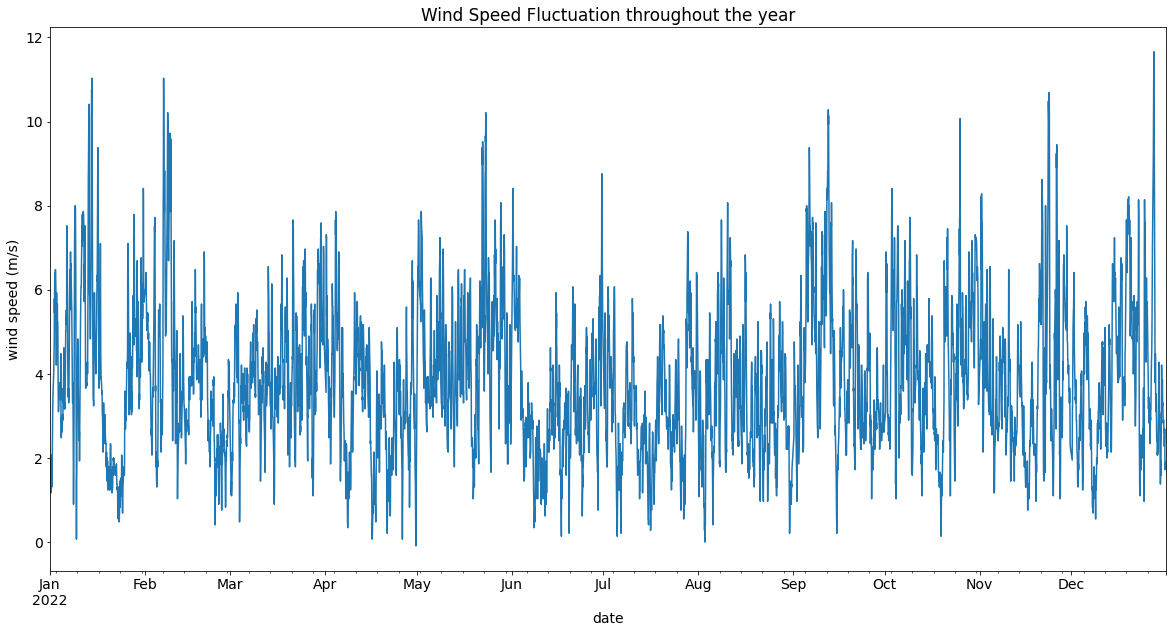

In [24]:
pd.DataFrame(weather_t['wind_speed']).plot(figsize=(20,10), legend=False)
plt.ylabel('wind speed (m/s)')
plt.title('Wind Speed Fluctuation throughout the year')

Text(0.5, 1.0, 'Ambient Temperature vs Cell Temperature Fluctuation for the first 7 days')

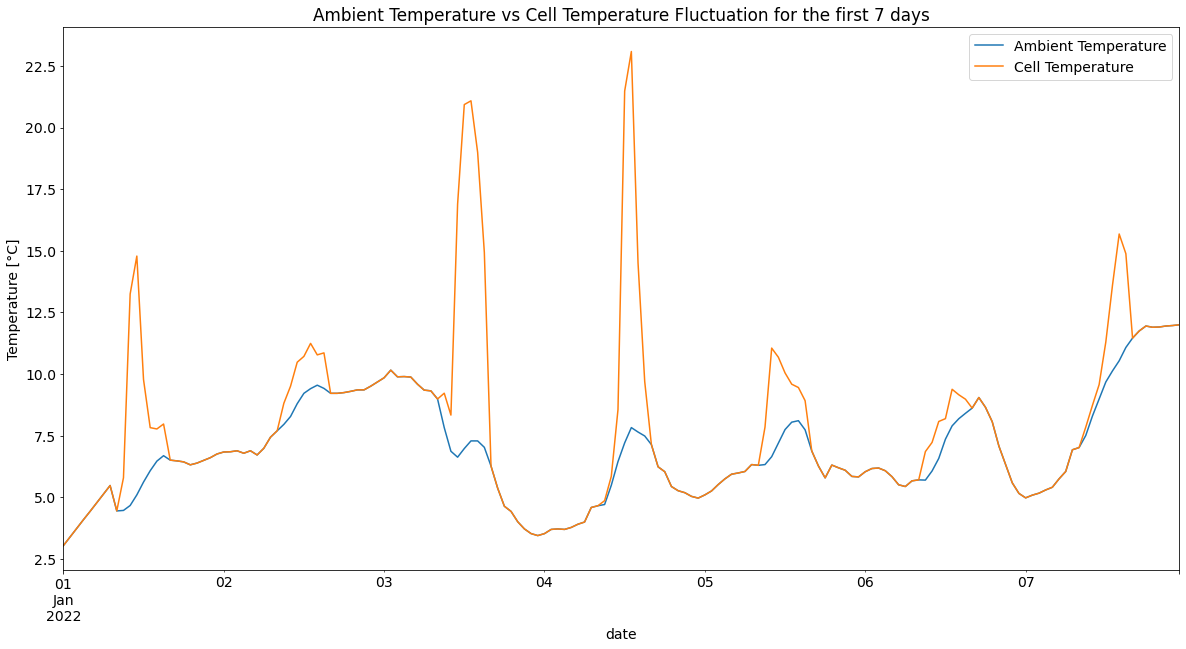

In [25]:
weather_t['temp_air'].head(24*7).plot(figsize=(20,10))
cell_temperature.head(24*7).plot()
plt.legend(['Ambient Temperature', 'Cell Temperature'])
plt.ylabel('Temperature [°C]');
plt.title('Ambient Temperature vs Cell Temperature Fluctuation for the first 7 days')

In [26]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C. Typically -0.002 to -0.005 per degree C
pdc0 = 420 # Nameplate DC rating

array_power = pvlib.pvsystem.pvwatts_dc(df_poa_global, cell_temperature, pdc0, gamma_pdc)

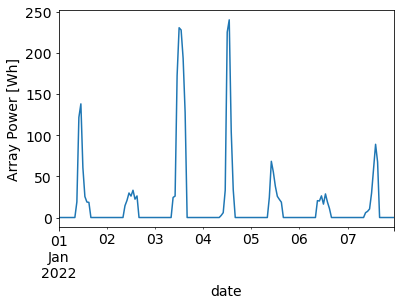

In [27]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [Wh]');

Text(0.5, 1.0, 'POA Received vs DC Power Converted')

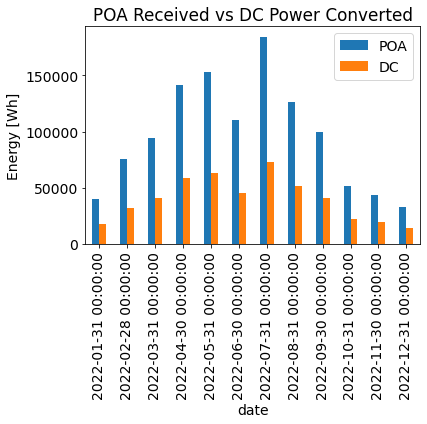

In [28]:
df_poa_dc = pd.DataFrame({
    'POA': df_poa_global,
    'DC': array_power,
})
# summing hourly power (W) gives (W h)
df_poa_dc.resample('M').sum().plot.bar()
plt.ylabel('Energy [Wh]')
plt.title('POA Received vs DC Power Converted')

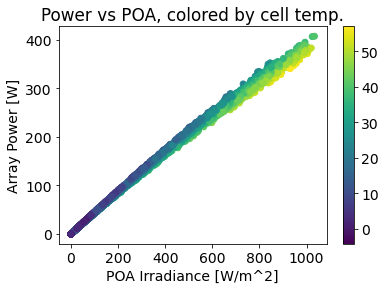

In [29]:
plt.scatter(df_poa_global, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

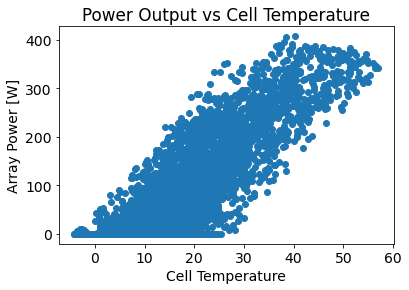

In [30]:
plt.scatter(cell_temperature, array_power)
plt.ylabel('Array Power [W]')
plt.xlabel('Cell Temperature')
plt.title('Power Output vs Cell Temperature');

In [31]:
print(model)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


In [32]:
model.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [33]:
ac_df = pd.DataFrame(model.results.ac.copy(), columns=['AC'])

In [34]:
daterange = pd.date_range(start='1/01/2022 00:00:00', end='31/12/2022 23:00:00', freq='H')
ac_df['date'] = daterange

In [35]:
ac_df.index = pd.to_datetime(ac_df['date'])
ac_df.drop('date', axis = 1, inplace = True)

Text(0.5, 1.0, 'Daily AC Power Production throughout the year')

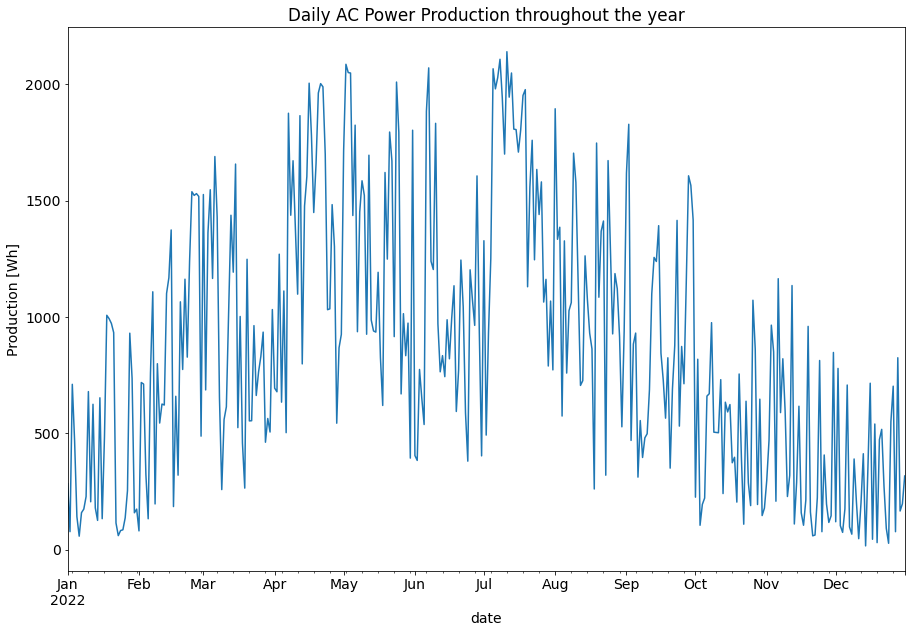

In [36]:
ac_df.resample('D').sum().plot(figsize=(15, 10), legend=False)
plt.ylabel('Production [Wh]');
plt.title('Daily AC Power Production throughout the year')

In [37]:
energy_prod = pd.DataFrame(model.results.dc['p_mp'])
energy_prod = energy_prod.rename(columns={'p_mp':'DC'})

In [38]:
energy_prod['date'] = daterange
energy_prod.index = pd.to_datetime(energy_prod['date'])
energy_prod.drop('date', axis = 1, inplace = True)

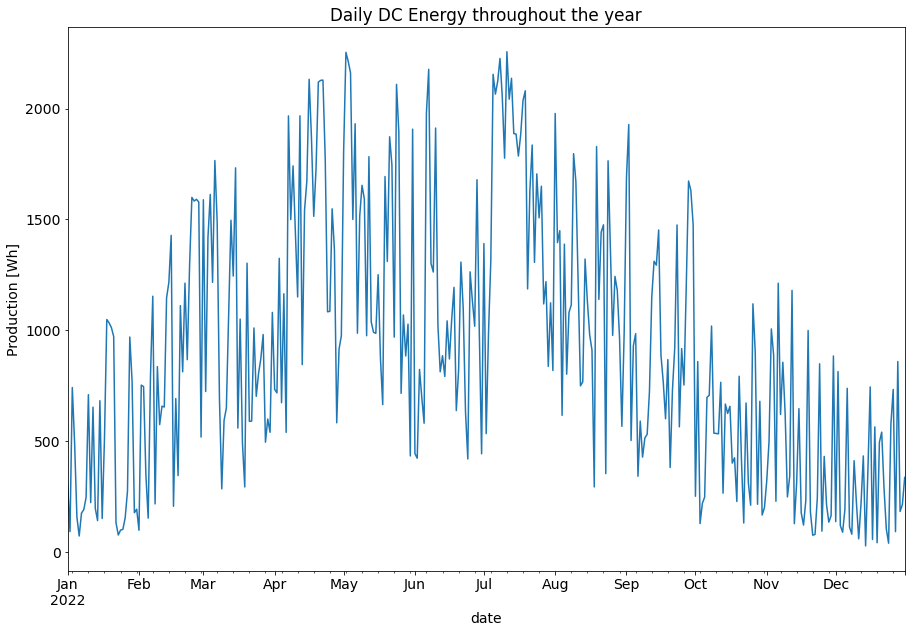

In [39]:
energy_prod.resample('D').sum().plot(title='Daily DC Energy throughout the year', figsize=(15, 10), legend=False)
plt.ylabel('Production [Wh]');

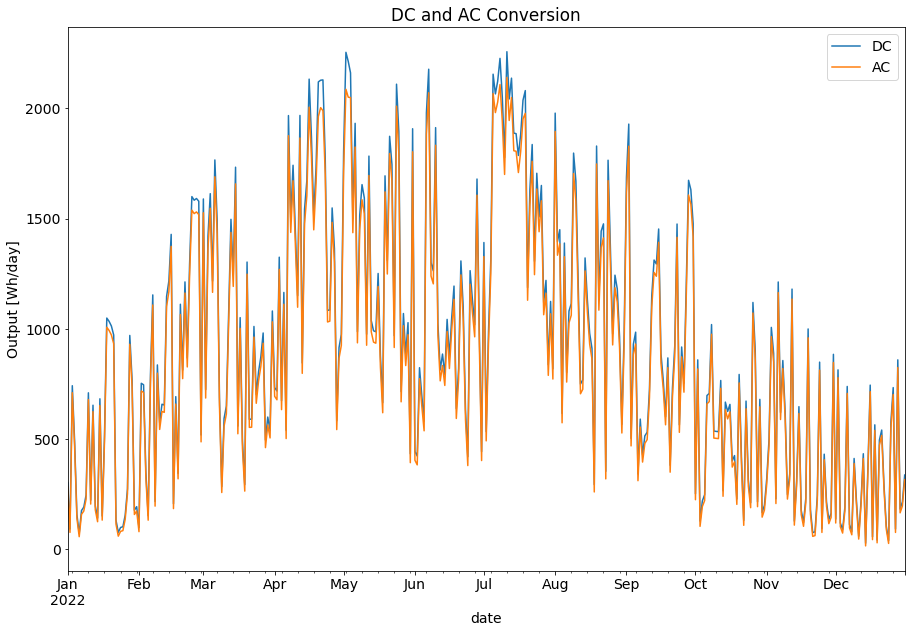

In [40]:
plt.rcParams['font.size'] = 14
ax = energy_prod.resample('D').sum().plot(figsize=(15, 10), label='DC')
ac_df.resample('D').sum().plot(ax=ax, label='AC')
plt.ylabel('Output [Wh/day]')
plt.title('DC and AC Conversion')
plt.legend()

Demand Data Ingestion to determine the number of solar modules needed to supply the new heat pump system

In [130]:
consumption_df = pd.read_excel('/Users/Asus/OneDrive/Energy Resource/energy consumption holywell house.xlsx')
winter_consumption_df = pd.read_excel('/Users/Asus/OneDrive/Energy Resource/winter energy consumption holywell house.xlsx')
summer_consumption_df = pd.read_excel('/Users/Asus/OneDrive/Energy Resource/summer energy consumption holywell house.xlsx')

In [131]:
monthly_consumption_df = pd.read_excel('/Users/Asus/OneDrive/Energy Resource/Gas Consumption.xlsx')

In [132]:
monthly_consumption_df

,Month,kWh
0,2022-01-31,15267
1,2022-02-28,9791
2,2022-03-31,9323
3,2022-04-30,4176
4,2022-05-31,697
5,2022-06-30,113
6,2022-07-31,102
7,2022-08-31,78
8,2022-09-30,112
9,2022-10-31,122


In [133]:
monthly_consumption_df.index = pd.to_datetime(monthly_consumption_df['Month'])
monthly_consumption_df.drop('Month', axis = 1, inplace = True)

Text(0, 0.5, 'Monthly Demand(kWh)')

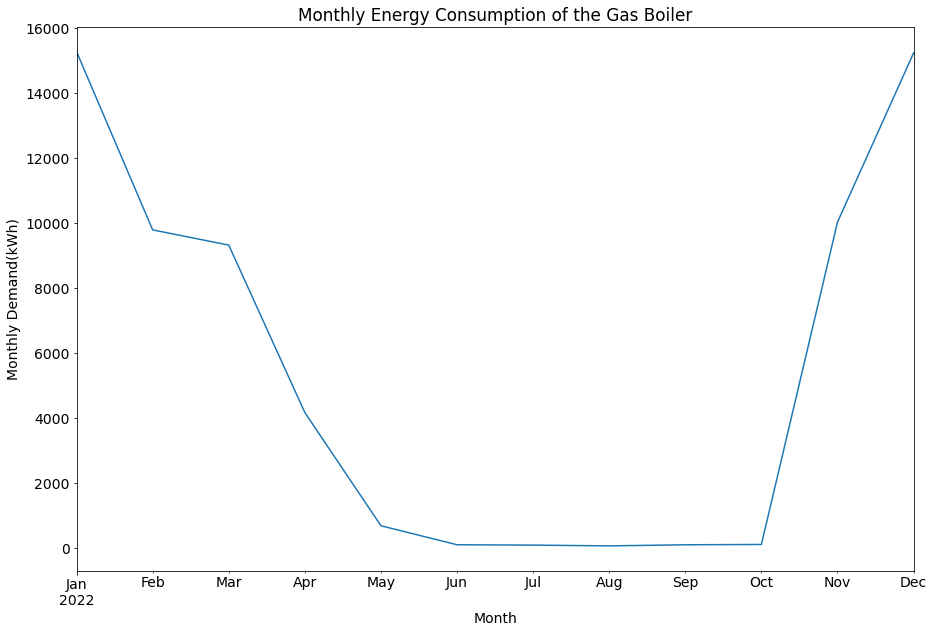

In [134]:
monthly_consumption_df.plot(figsize=(15,10), title='Monthly Energy Consumption of the Gas Boiler', legend=False)
plt.ylabel('Monthly Demand(kWh)')

In [135]:
consumption_df

,Time,KW
0,2022-10-11 00:00:00,6.32
1,2022-10-11 00:01:00,3.39
2,2022-10-11 00:02:00,3.80
3,2022-10-11 00:03:00,3.92
4,2022-10-11 00:04:00,3.97
...,...,...
1281,2022-10-11 23:54:00,3.52
1282,2022-10-11 23:55:00,9.62
1283,2022-10-11 23:56:00,6.31
1284,2022-10-11 23:57:00,3.78


In [136]:
winter_consumption_df

,Time,KW
0,2022-12-21 00:00:00,6.32
1,2022-12-21 00:01:00,3.39
2,2022-12-21 00:02:00,3.80
3,2022-12-21 00:03:00,3.92
4,2022-12-21 00:04:00,3.97
...,...,...
1281,2022-12-21 23:54:00,3.52
1282,2022-12-21 23:55:00,9.62
1283,2022-12-21 23:56:00,6.31
1284,2022-12-21 23:57:00,3.78


In [137]:
summer_consumption_df

,Time,KW
0,2022-06-21 00:00:00,6.32
1,2022-06-21 00:01:00,3.39
2,2022-06-21 00:02:00,3.80
3,2022-06-21 00:03:00,3.92
4,2022-06-21 00:04:00,3.97
...,...,...
1281,2022-06-21 23:54:00,3.52
1282,2022-06-21 23:55:00,9.62
1283,2022-06-21 23:56:00,6.31
1284,2022-06-21 23:57:00,3.78


In [138]:
consumption_df.index = pd.to_datetime(consumption_df['Time'])

In [139]:
winter_consumption_df.index = pd.to_datetime(winter_consumption_df['Time'])

In [140]:
summer_consumption_df.index = pd.to_datetime(summer_consumption_df['Time'])

In [141]:
consumption_df.drop('Time', axis = 1, inplace = True)

Text(0, 0.5, 'Demand(kWh)')

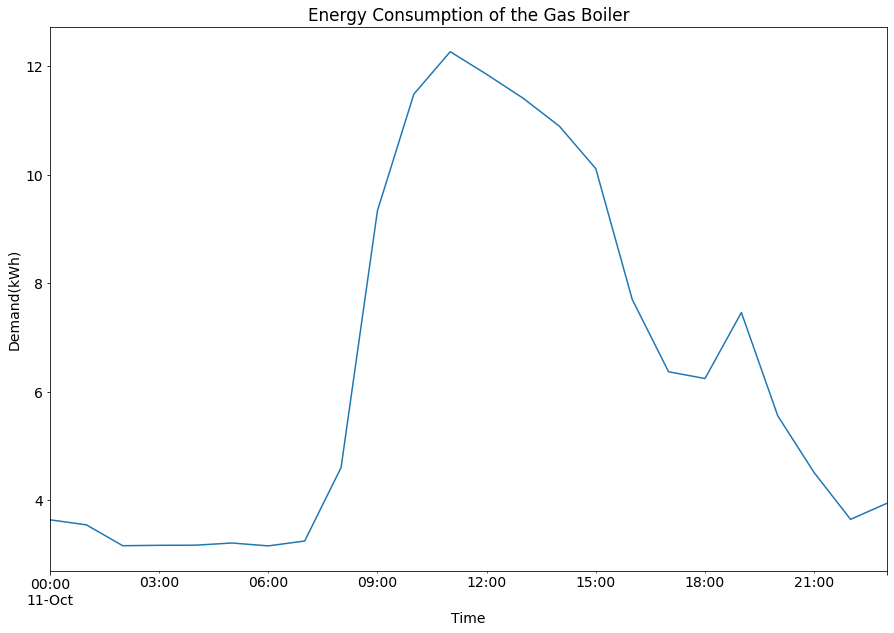

In [142]:
(consumption_df*(1/60)).resample('H').sum().plot(figsize=(15,10), title='Energy Consumption of the Gas Boiler', legend=False)
plt.ylabel('Demand(kWh)')

In [143]:
winter_consumption_df.drop('Time', axis = 1, inplace = True)

In [144]:
summer_consumption_df.drop('Time', axis = 1, inplace = True)

In [145]:
consumption_df = consumption_df.rename(columns={'KW':'Demand(kWh)'})
winter_consumption_df = winter_consumption_df.rename(columns={'KW':'Demand(kWh)'})
summer_consumption_df = summer_consumption_df.rename(columns={'KW':'Demand(kWh)'})

# Converting the kW data in minute interval to kWh and then divide it by the PER of heat pump to obtain the estimated demand for
# the new heat pump
consumption_df = consumption_df*(1/60)*(1/4)
winter_consumption_df = winter_consumption_df*(1/60)*(1/4)*1.2
summer_consumption_df = summer_consumption_df*(1/60)*(1/4)*0.8

In [146]:
# Calculating the annual energy production
consumption_df.resample('H').sum().sum()

Demand(kWh)    38.439375
dtype: float64

In [147]:
# Calculating the kWp under peak environmental conditions
consumption_df.resample('H').sum().max()

Demand(kWh)    3.067083
dtype: float64

Text(0.5, 1.0, 'Newly Installed Heat Pump Energy Demand')

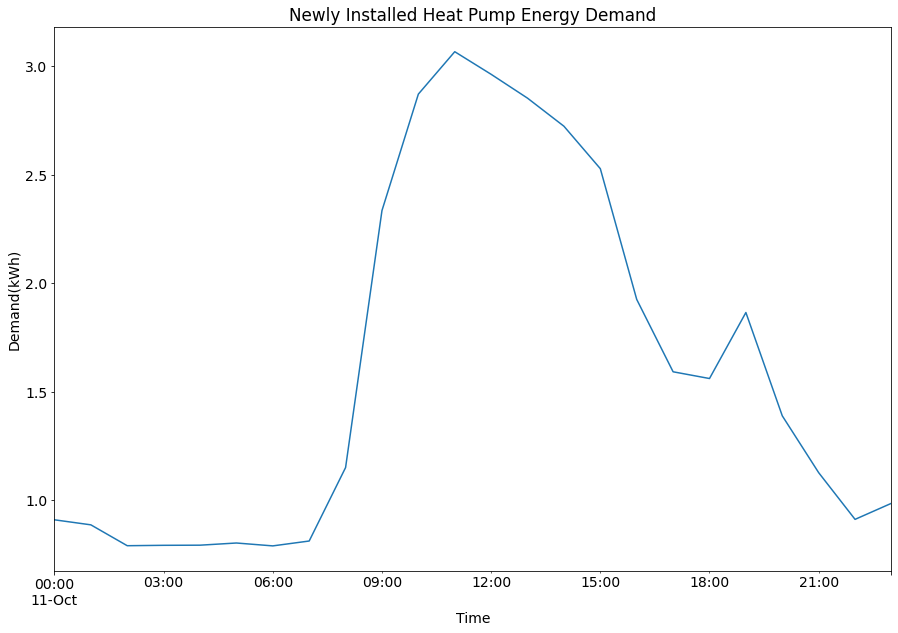

In [148]:
consumption_df.resample('H').sum().plot(figsize=(15,10), legend=False)
plt.ylabel('Demand(kWh)')
plt.title('Newly Installed Heat Pump Energy Demand')

Assuming the PV system is composed of 100 PV modules, the total PV system generation will be computed and used to match the heat pump demand.

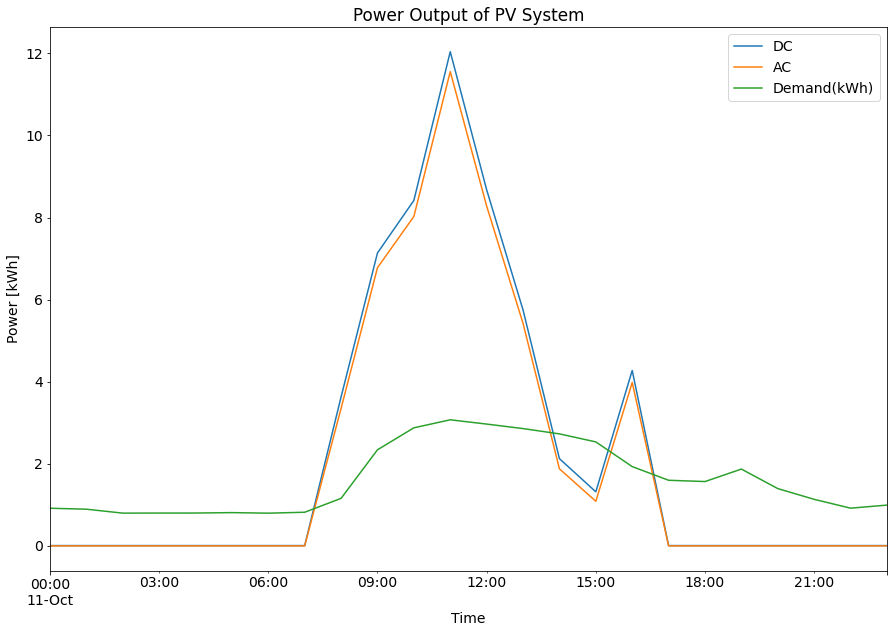

In [149]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod.loc['2022-10-11']*0.1).plot(label='DC power', ax=ax)
(ac_df.loc['2022-10-11']*0.1).plot(label='AC power', ax=ax)
consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System')
plt.show() 

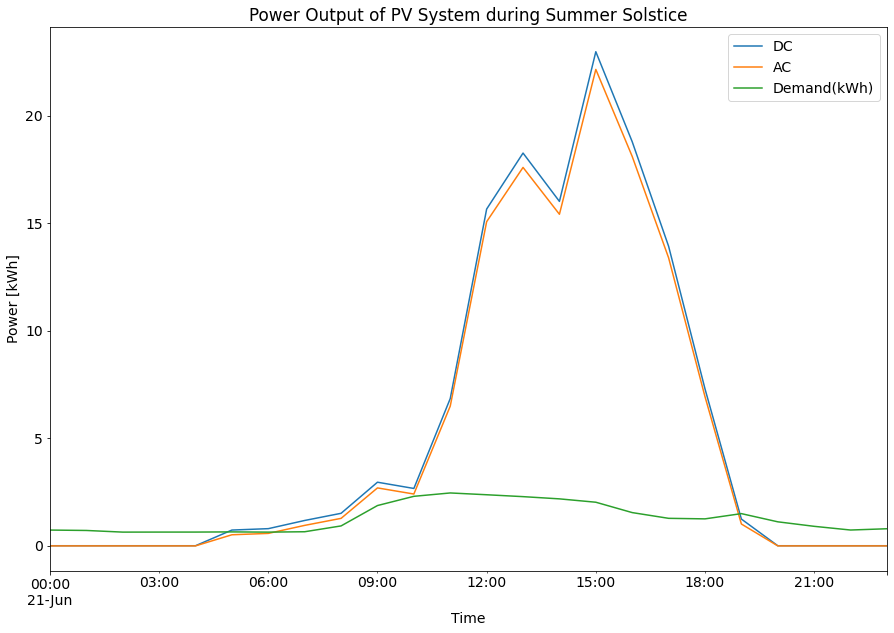

In [150]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod.loc['2022-06-21']*0.1).plot(label='DC power', ax=ax)
(ac_df.loc['2022-06-21']*0.1).plot(label='AC power', ax=ax)
summer_consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System during Summer Solstice')
plt.show() 

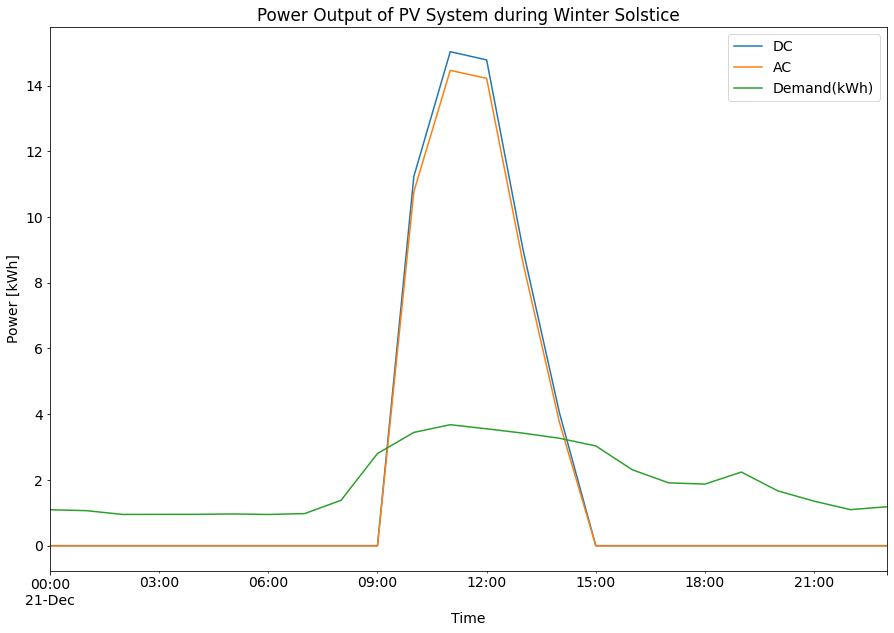

In [151]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod.loc['2022-12-21']*0.1).plot(label='DC power', ax=ax)
(ac_df.loc['2022-12-21']*0.1).plot(label='AC power', ax=ax)
winter_consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System during Winter Solstice')
plt.show() 

In [152]:
(energy_prod*0.1).sum()

DC    33823.171854
dtype: float64

In [153]:
(energy_prod*0.1).max()

DC    29.316151
dtype: float64

In [154]:
demand = consumption_df.resample('H').sum()
winter_demand = winter_consumption_df.resample('H').sum()
summer_demand = summer_consumption_df.resample('H').sum()

In [155]:
supply = energy_prod.loc['2022-10-11']*0.1
winter_supply = energy_prod.loc['2022-12-21']*0.1
summer_supply = energy_prod.loc['2022-06-21']*0.1

Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing')

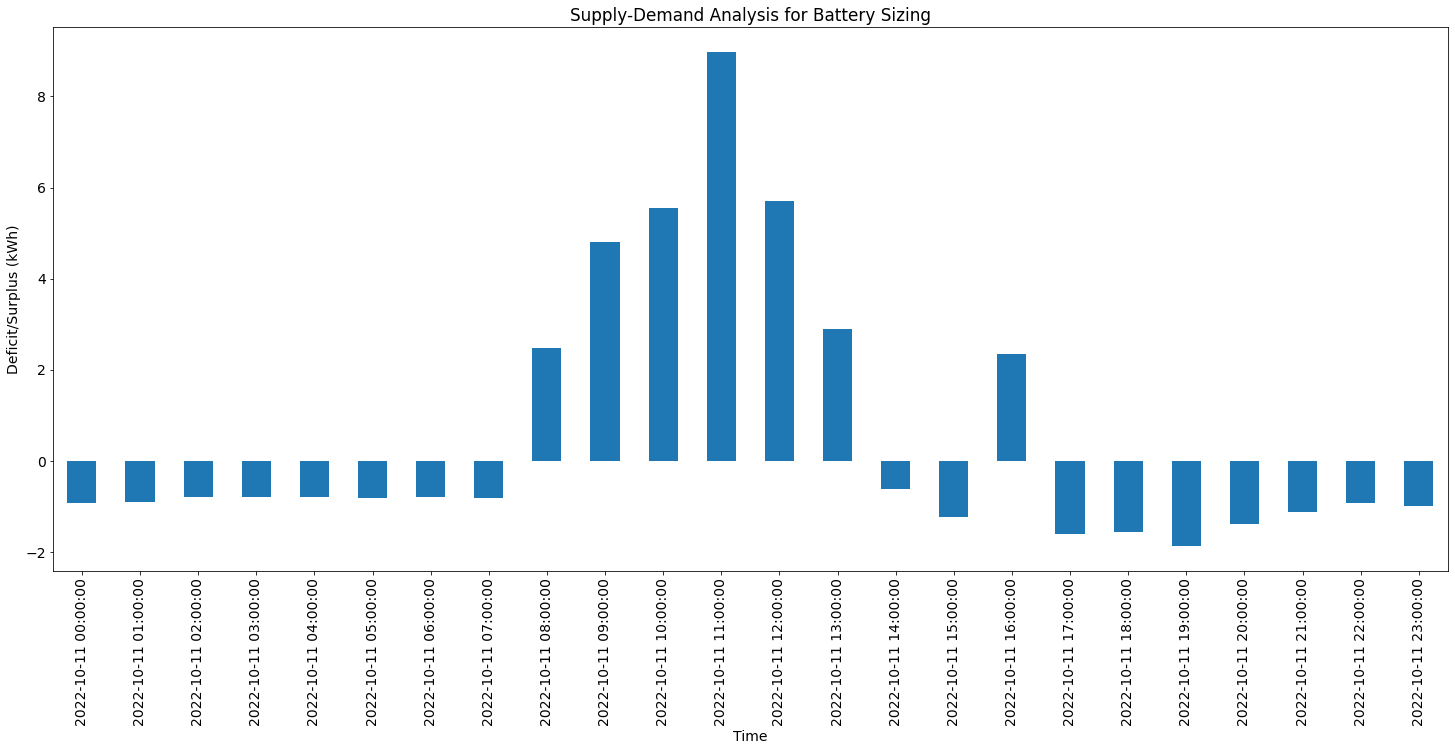

In [156]:
deficit_surplus = []
for time in demand.index:
    net = supply.loc[time].values - demand.loc[time].values 
    deficit_surplus.append(net)
    
battery_power = pd.DataFrame(deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=demand.index)
battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing')

In [157]:
discharge = 0
charge = 0
for i in battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        discharge += i
    else:
        charge += i

print(discharge)
print(charge)
print(battery_power.sum())

-17.84054780652924
32.744703461718075
Deficit/Surplus (kWh)    14.904156
dtype: float64


Winter Demand-Supply Analysis

Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing during Winter Solstice')

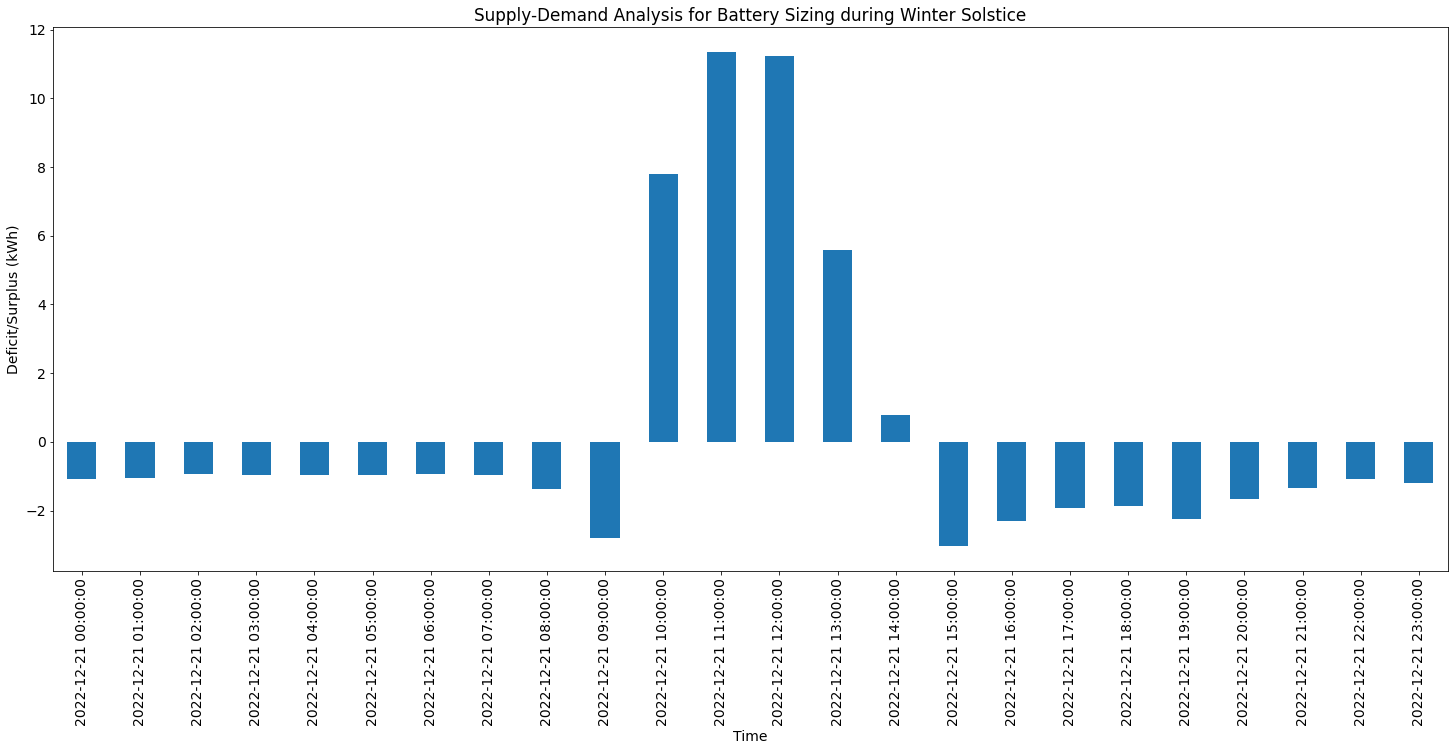

In [158]:
winter_deficit_surplus = []
for time in winter_demand.index:
    net = winter_supply.loc[time].values - winter_demand.loc[time].values 
    winter_deficit_surplus.append(net)
    
winter_battery_power = pd.DataFrame(winter_deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=winter_demand.index)
winter_battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing during Winter Solstice')

In [159]:
winter_discharge = 0
winter_charge = 0
for i in winter_battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        winter_discharge += i
    else:
        winter_charge += i

print(winter_discharge)
print(winter_charge)
print(winter_battery_power.sum())

-28.752899999999997
36.72834125385141
Deficit/Surplus (kWh)    7.975441
dtype: float64


Summer Demand-Supply Analysis

Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing during Summer Solstice')

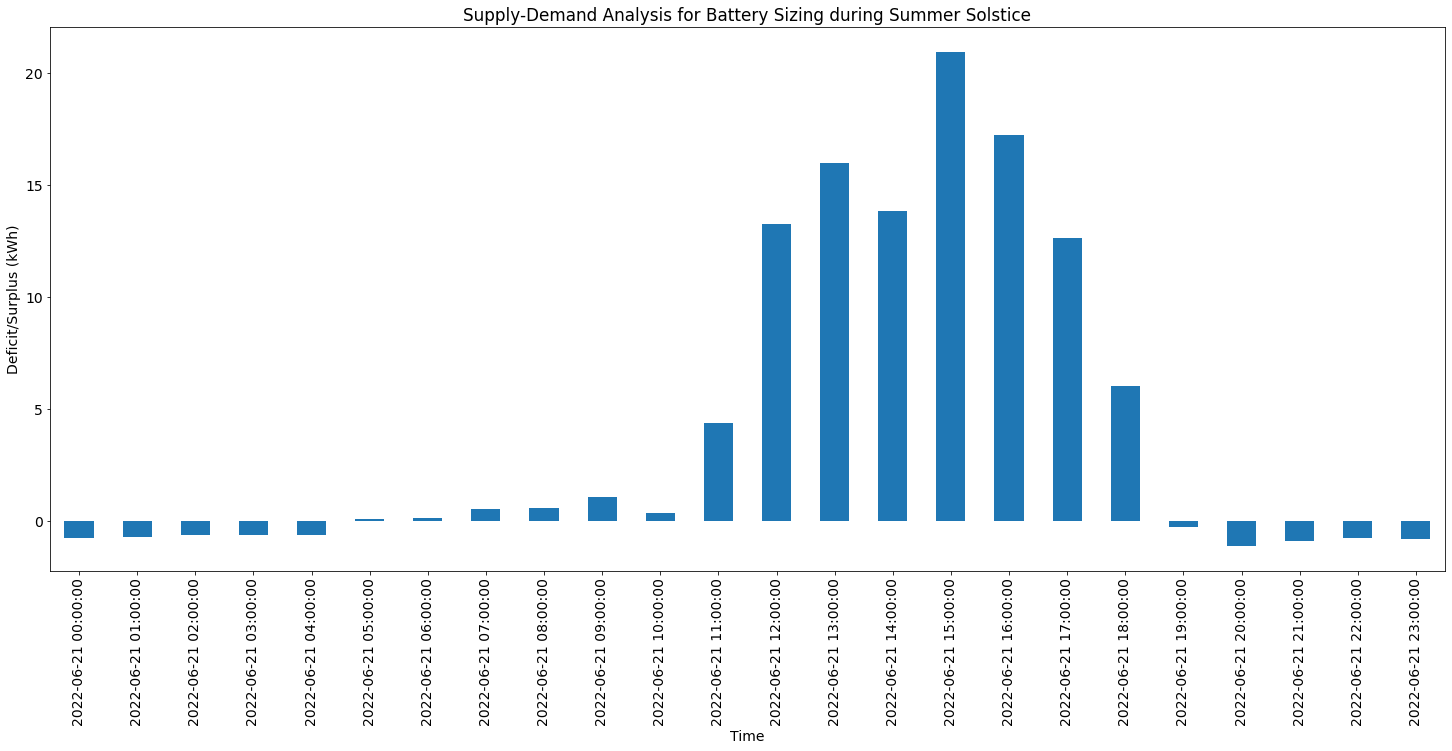

In [160]:
summer_deficit_surplus = []
for time in summer_demand.index:
    net = summer_supply.loc[time].values - summer_demand.loc[time].values 
    summer_deficit_surplus.append(net)
    
summer_battery_power = pd.DataFrame(summer_deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=summer_demand.index)
summer_battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing during Summer Solstice')

In [161]:
summer_discharge = 0
summer_charge = 0
for i in summer_battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        summer_discharge += i
    else:
        summer_charge += i

print(summer_discharge)
print(summer_charge)
print(summer_battery_power.sum())

-7.127030825061936
107.17104708644383
Deficit/Surplus (kWh)    100.044016
dtype: float64


## Shading Consideration
### Considering different shading scenario through a “shaded fraction” concept. It refers to the fraction of the module that receives global POA irradiance.

In [162]:
# Creating a model for the specified set of parameters used
model_loss = ModelChain(system, location, losses_model='pvwatts')

In [163]:
model_loss.run_model(weather_t)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: pvwatts_losses

In [164]:
ac_df_loss = pd.DataFrame(model_loss.results.ac.copy(), columns=['AC(With Loss Model)'])
daterange = pd.date_range(start='1/01/2022 00:00:00', end='31/12/2022 23:00:00', freq='H')
ac_df_loss['date'] = daterange
ac_df_loss.index = pd.to_datetime(ac_df_loss['date'])
ac_df_loss.drop('date', axis = 1, inplace = True)

In [165]:
energy_prod_loss = pd.DataFrame(model_loss.results.dc['p_mp'])
energy_prod_loss['date'] = daterange
energy_prod_loss.index = pd.to_datetime(energy_prod_loss['date'])
energy_prod_loss.drop('date', axis = 1, inplace = True)

In [166]:
energy_prod_loss = energy_prod_loss.rename(columns={'p_mp':'DC(With Loss Model)'})

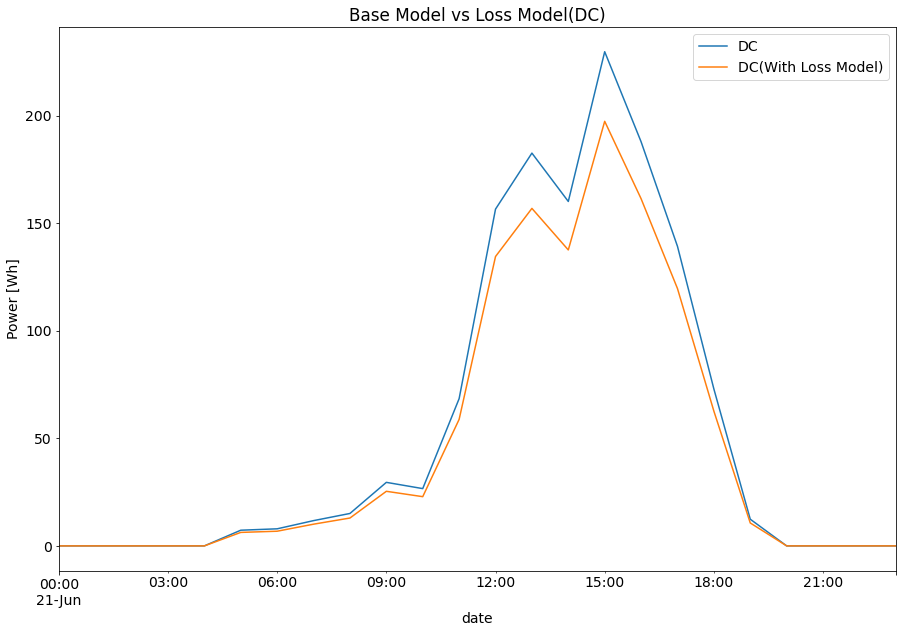

In [167]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod.loc['2022-06-21']).plot(label='base', ax=ax)
(energy_prod_loss.loc['2022-06-21']).plot(label='loss', ax=ax)
ax.set_ylabel('Power [Wh]')
ax.set_title('Base Model vs Loss Model(DC)')
plt.show() 

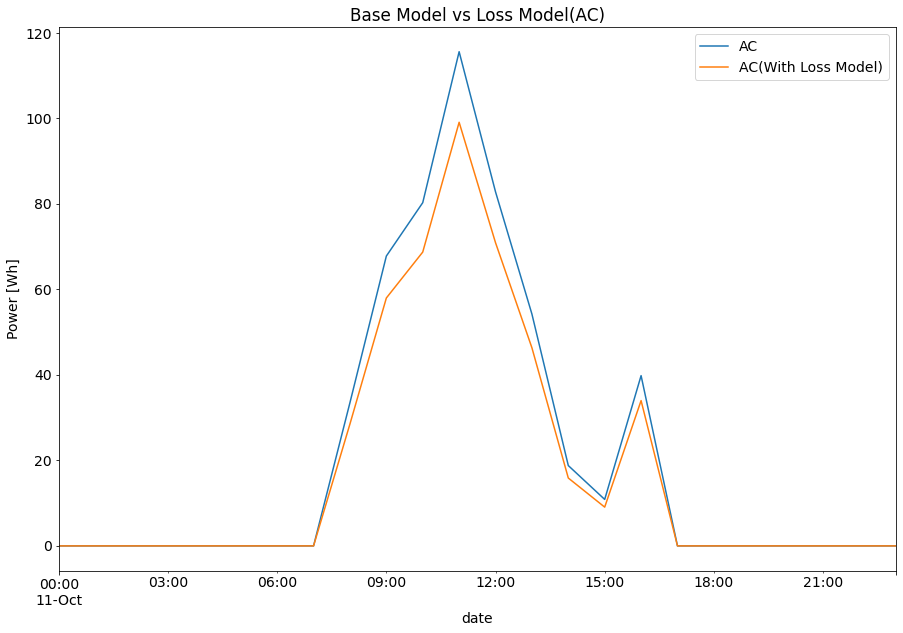

In [168]:
fig, ax = plt.subplots(figsize=(15, 10))
(ac_df.loc['2022-10-11']).plot(label='base', ax=ax)
(ac_df_loss.loc['2022-10-11']).plot(label='loss', ax=ax)
ax.set_ylabel('Power [Wh]')
ax.set_title('Base Model vs Loss Model(AC)')
plt.show() 

In [169]:
(energy_prod_loss*0.1).sum()

DC(With Loss Model)    29068.841755
dtype: float64

In [170]:
(energy_prod_loss*0.1).max()

DC(With Loss Model)    25.19126
dtype: float64

In [189]:
(energy_prod_loss.loc['2022-06-11']*0.1).max()

DC(With Loss Model)    16.043753
dtype: float64

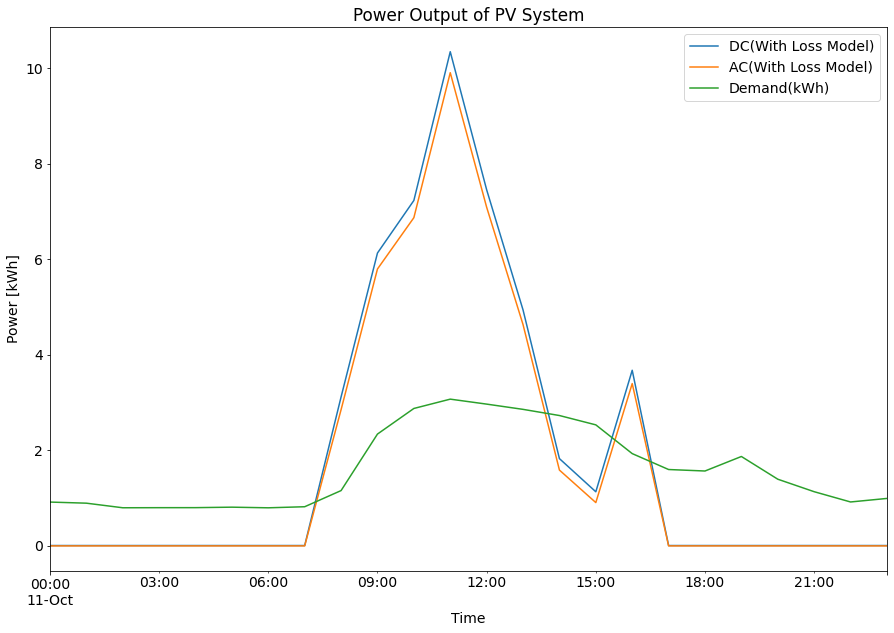

In [171]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod_loss.loc['2022-10-11']*0.1).plot(label='DC power', ax=ax)
(ac_df_loss.loc['2022-10-11']*0.1).plot(label='AC power', ax=ax)
consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System')
plt.show() 

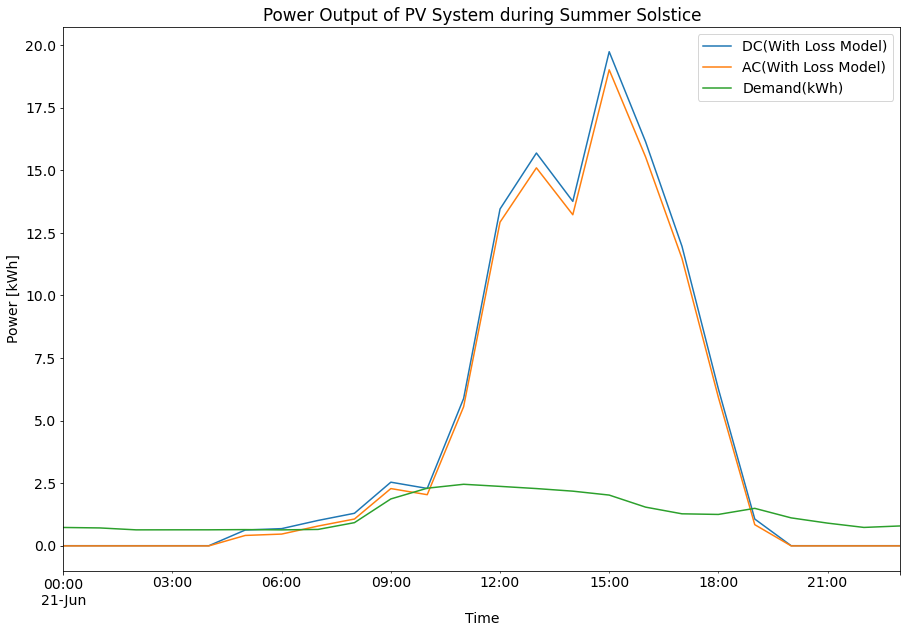

In [172]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod_loss.loc['2022-06-21']*0.1).plot(label='DC power', ax=ax)
(ac_df_loss.loc['2022-06-21']*0.1).plot(label='AC power', ax=ax)
summer_consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System during Summer Solstice')
plt.show() 

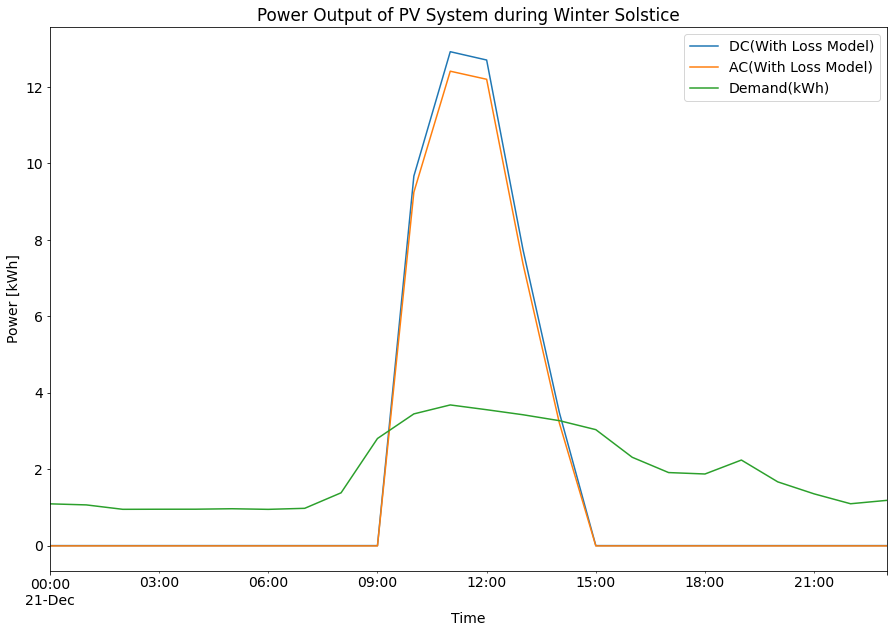

In [173]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod_loss.loc['2022-12-21']*0.1).plot(label='DC power', ax=ax)
(ac_df_loss.loc['2022-12-21']*0.1).plot(label='AC power', ax=ax)
winter_consumption_df.resample('H').sum().plot(label='Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Power Output of PV System during Winter Solstice')
plt.show() 

In [174]:
supply_loss = energy_prod_loss.loc['2022-10-11']*0.1
winter_supply_loss = energy_prod_loss.loc['2022-12-21']*0.1
summer_supply_loss = energy_prod_loss.loc['2022-06-21']*0.1

Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing on 11/10/2022')

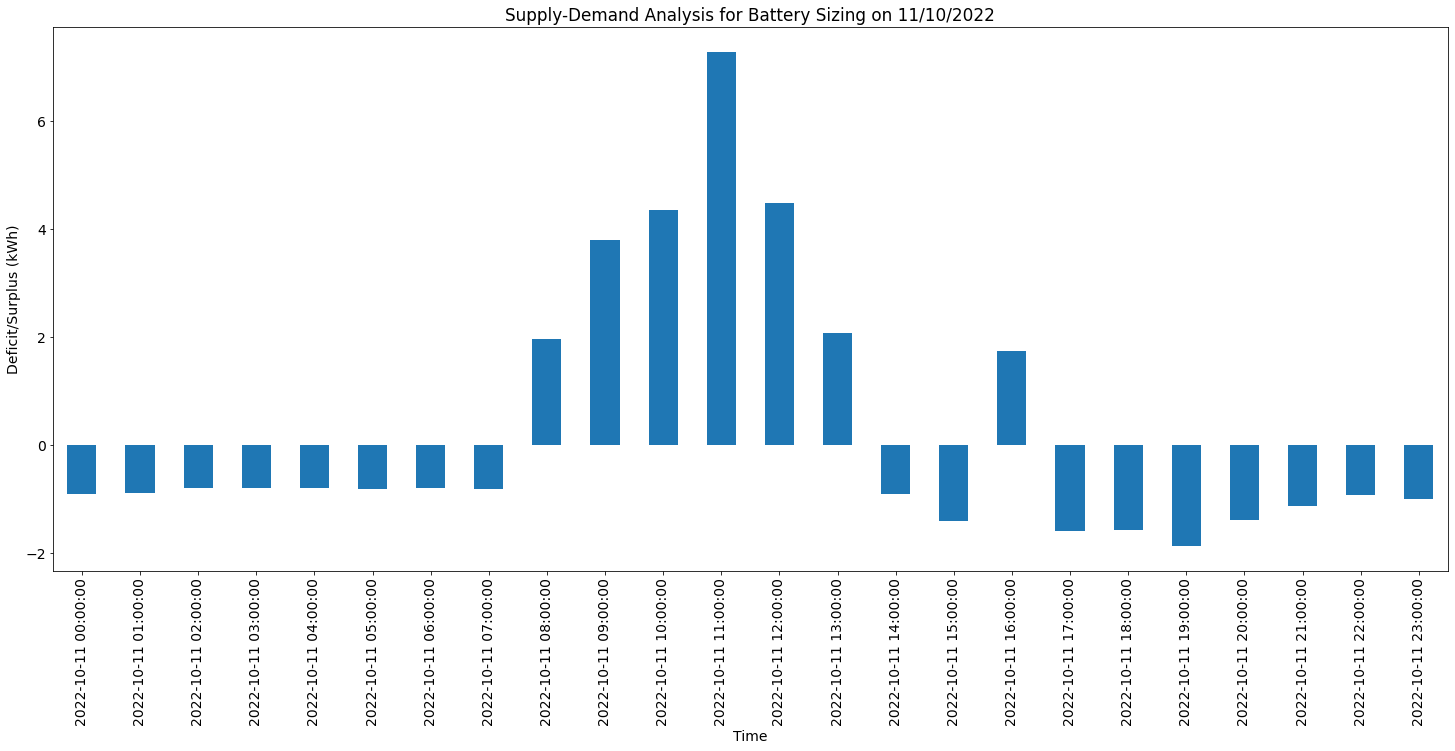

In [175]:
deficit_surplus = []
for time in demand.index:
    net = supply_loss.loc[time].values - demand.loc[time].values 
    deficit_surplus.append(net)
    
battery_power = pd.DataFrame(deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=demand.index)
battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing on 11/10/2022')

In [176]:
discharge = 0
charge = 0
for i in battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        discharge += i
    else:
        charge += i

print(discharge)
print(charge)
print(battery_power.sum())

-18.324444566543228
25.71303457112752
Deficit/Surplus (kWh)    7.38859
dtype: float64


Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing during Winter Solstice')

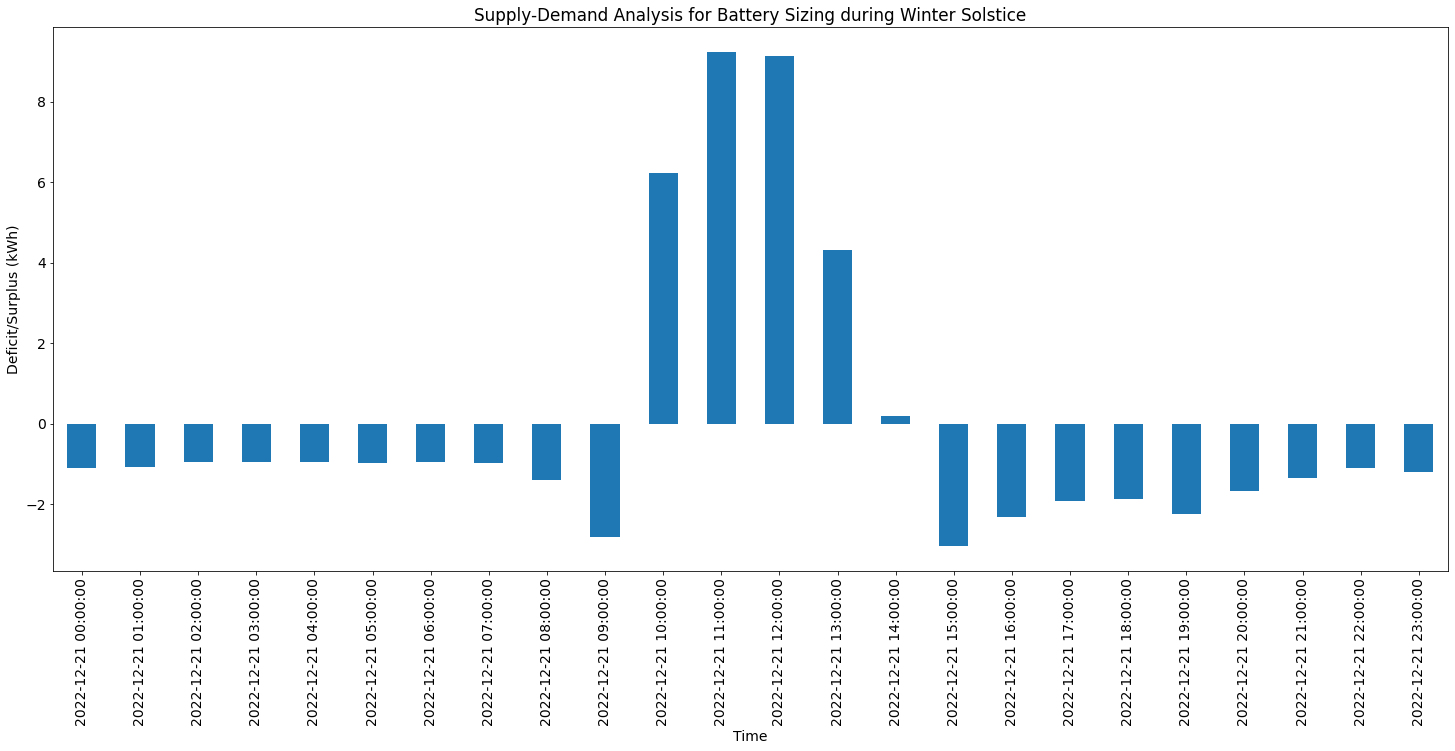

In [177]:
winter_deficit_surplus = []
for time in winter_demand.index:
    net = winter_supply_loss.loc[time].values - winter_demand.loc[time].values 
    winter_deficit_surplus.append(net)
    
winter_battery_power = pd.DataFrame(winter_deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=winter_demand.index)
winter_battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing during Winter Solstice')

In [178]:
winter_discharge = 0
winter_charge = 0
for i in winter_battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        winter_discharge += i
    else:
        winter_charge += i

print(winter_discharge)
print(winter_charge)
print(winter_battery_power.sum())

-28.752899999999997
29.136155597844073
Deficit/Surplus (kWh)    0.383256
dtype: float64


Text(0.5, 1.0, 'Supply-Demand Analysis for Battery Sizing during Summer Solstice')

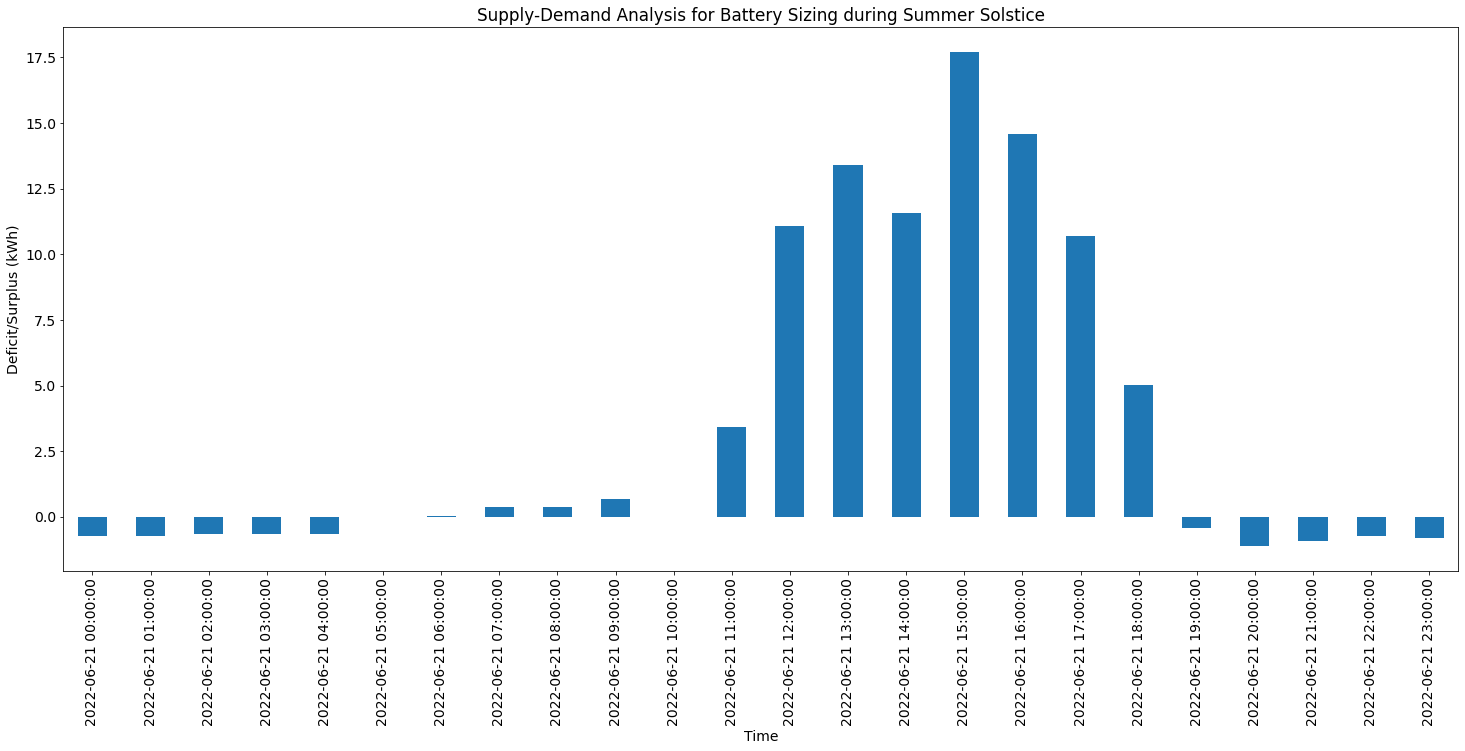

In [179]:
summer_deficit_surplus = []
for time in summer_demand.index:
    net = summer_supply_loss.loc[time].values - summer_demand.loc[time].values 
    summer_deficit_surplus.append(net)
    
summer_battery_power = pd.DataFrame(summer_deficit_surplus, columns=['Deficit/Surplus (kWh)'], index=summer_demand.index)
summer_battery_power.plot.bar(figsize=(25,10), legend=False)
plt.ylabel('Deficit/Surplus (kWh)')
plt.title('Supply-Demand Analysis for Battery Sizing during Summer Solstice')

In [180]:
summer_discharge = 0
summer_charge = 0
for i in summer_battery_power['Deficit/Surplus (kWh)']:
    if i < 0:
        summer_discharge += i
    else:
        summer_charge += i

print(summer_discharge)
print(summer_charge)
print(summer_battery_power.sum())

-7.327517463645042
88.94977119973515
Deficit/Surplus (kWh)    81.622254
dtype: float64


In [181]:
energy_prod_loss.resample('m').sum()

,DC(With Loss Model)
date,
2022-01-31,10991.526567
2022-02-28,20800.479420
2022-03-31,25395.701939
2022-04-30,36033.116362
2022-05-31,37654.305151
2022-06-30,26398.971952
2022-07-31,43444.769699
2022-08-31,30883.161729
2022-09-30,25104.648697


In [123]:
monthly_consumption_df = monthly_consumption_df.rename(columns={'kWh': 'Monthly Demand'})

In [182]:
monthly_consumption_df*(1/4)

,kWh
Month,
2022-01-31,3816.75
2022-02-28,2447.75
2022-03-31,2330.75
2022-04-30,1044.00
2022-05-31,174.25
2022-06-30,28.25
2022-07-31,25.50
2022-08-31,19.50
2022-09-30,28.00


In [183]:
(energy_prod_loss*0.1).resample('M').sum()

,DC(With Loss Model)
date,
2022-01-31,1099.152657
2022-02-28,2080.047942
2022-03-31,2539.570194
2022-04-30,3603.311636
2022-05-31,3765.430515
2022-06-30,2639.897195
2022-07-31,4344.476970
2022-08-31,3088.316173
2022-09-30,2510.464870


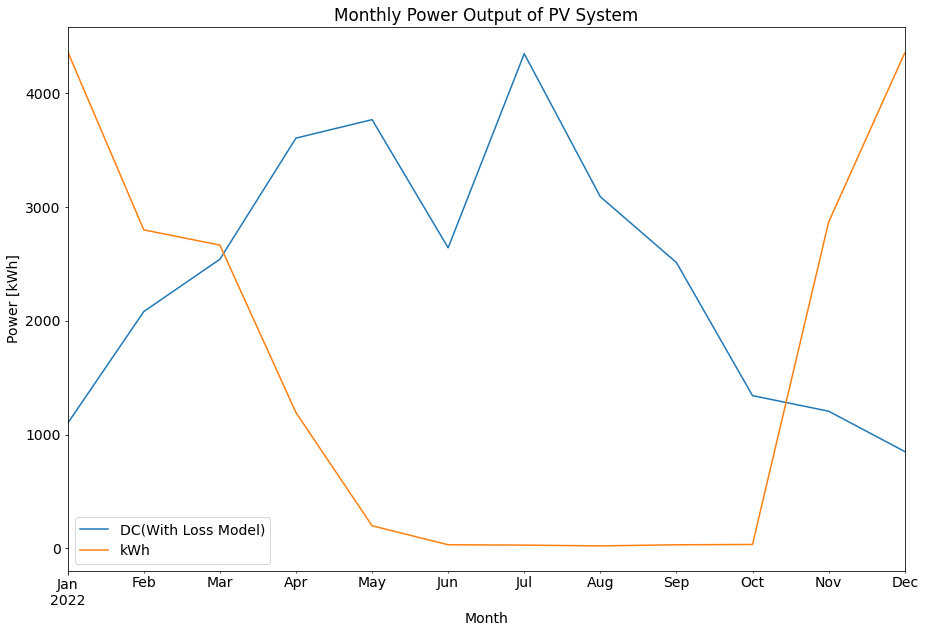

In [185]:
fig, ax = plt.subplots(figsize=(15, 10))
(energy_prod_loss*0.1).resample('m').sum().plot(label='DC power', ax=ax)
(monthly_consumption_df*(1/3.5)).plot(label='Monthly Energy demand', ax=ax)
ax.set_ylabel('Power [kWh]')
ax.set_title('Monthly Power Output of PV System')
plt.show() 